# Dimensionality Reduction

In this notebook, we aim at comparing the classification performances of the different classifiers on original data and data after their dimensions are reduced.   

In [1]:
# Loading data then split them into training and testing sets 

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')


mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"][:10000]
y = mnist["target"][:10000]


In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape

(7000, 784)

In [3]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### Loading some classifiers 

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [5]:
log_clf = LogisticRegression()
sgd_clf = SGDClassifier()
rnd_clf = RandomForestClassifier()

In [6]:
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl

In [7]:
print('Results on original data:')
t0 = time.time()

for clf in (log_clf, sgd_clf, rnd_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

t1 = time.time()
t_original_data = t1 - t0
print('Processing time: ', t_original_data)

Results on original data:
LogisticRegression 0.831
SGDClassifier 0.884
RandomForestClassifier 0.906
Processing time:  115.632652759552


Now we apply dimensionality reduction techniques to the data then we train and test the model again on the data whose dimensions are reduced.

## Principal component analysis (PCA)

**PCA** is one of the most popular dimensionality reduction methods   

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

149

In [12]:
n_comp = 28
d = n_comp

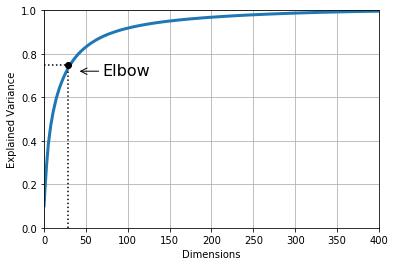

In [30]:
# Plotting the variance of the data 

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([n_comp, n_comp], [0, 0.75], "k:")
plt.plot([0, n_comp], [0.75, 0.75], "k:")
plt.plot(n_comp, 0.75, "ko")
plt.annotate("Elbow", xy=(40, 0.72), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [15]:
# Keeping only n_component dimensions since it contains much of the variance in the data 
pca = PCA(n_components = n_comp)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Now train and test the performance on the new data. 

In [16]:
print('Results on PCA data:')
import time

t0 = time.time()

for clf in (log_clf, sgd_clf, rnd_clf):
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

t1 = time.time()
t_pca_data = t1 - t0
print('Processing time: ', t_pca_data)

Results on PCA data:
LogisticRegression 0.8783333333333333
SGDClassifier 0.7423333333333333
RandomForestClassifier 0.8903333333333333
Processing time:  3.418328046798706


## Isomap

In [17]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=n_comp)
X_train_isomap = isomap.fit_transform(X_train)
X_test_isomap = isomap.transform(X_test)


In [18]:
print('Results on Isomap data:')

t0 = time.time()
for clf in (log_clf, sgd_clf, rnd_clf):
    clf.fit(X_train_isomap, y_train)
    y_pred = clf.predict(X_test_isomap)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    
t1 = time.time()
t_isomap_data = t1 - t0
print('Processing time: ', t_isomap_data)

Results on Isomap data:
LogisticRegression 0.9196666666666666
SGDClassifier 0.7353333333333333
RandomForestClassifier 0.9216666666666666
Processing time:  4.667878866195679


## Lolcally Linear Embedding (LLE)

In [19]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=n_comp, n_neighbors=10, random_state=42)
X_train_lle = lle.fit_transform(X_train)
X_test_lle = lle.transform(X_test)

In [21]:
print('Results on LLE data:')
t0 = time.time()


for clf in (log_clf, sgd_clf, rnd_clf):
    clf.fit(X_train_lle, y_train)
    y_pred = clf.predict(X_test_lle)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

t1 = time.time()
t_lle_data = t1 - t0
print('Processing time: ', t_lle_data)

Results on LLE data:
LogisticRegression 0.9688888888888889
SGDClassifier 0.9688888888888889
RandomForestClassifier 0.9822222222222222
Processing time:  0.09686899185180664


In order to make it easy for us to visualize the dimensionality reduction performance, we will reduce the dimensions to two dimensional space then plot them. 

In [20]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

In [21]:
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)

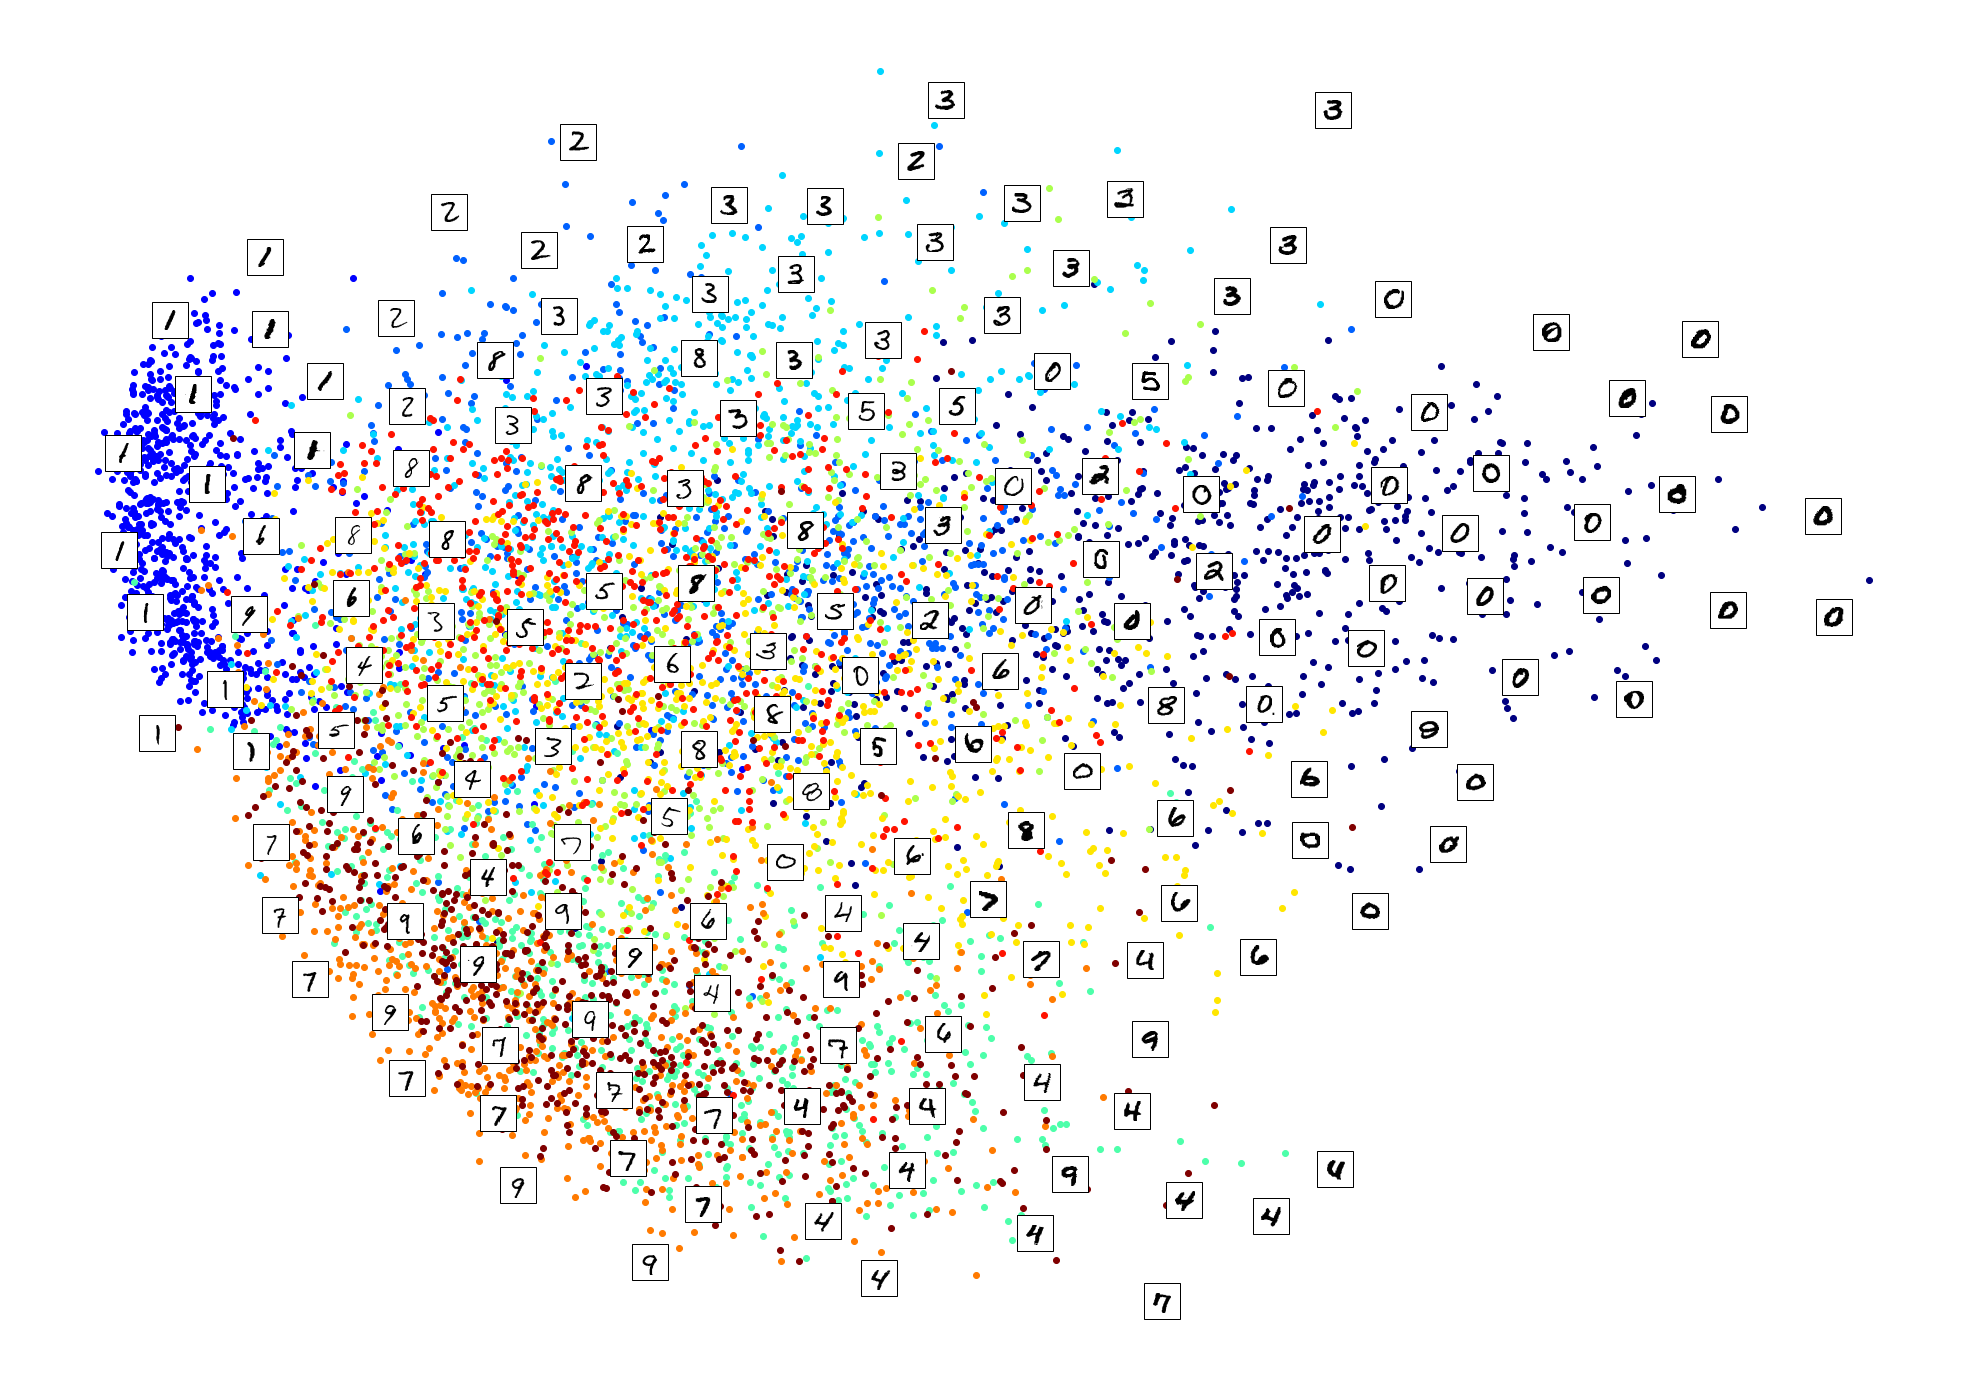

In [22]:
plot_digits(X_train_pca, y_train, images=X_train, figsize=(35, 25))

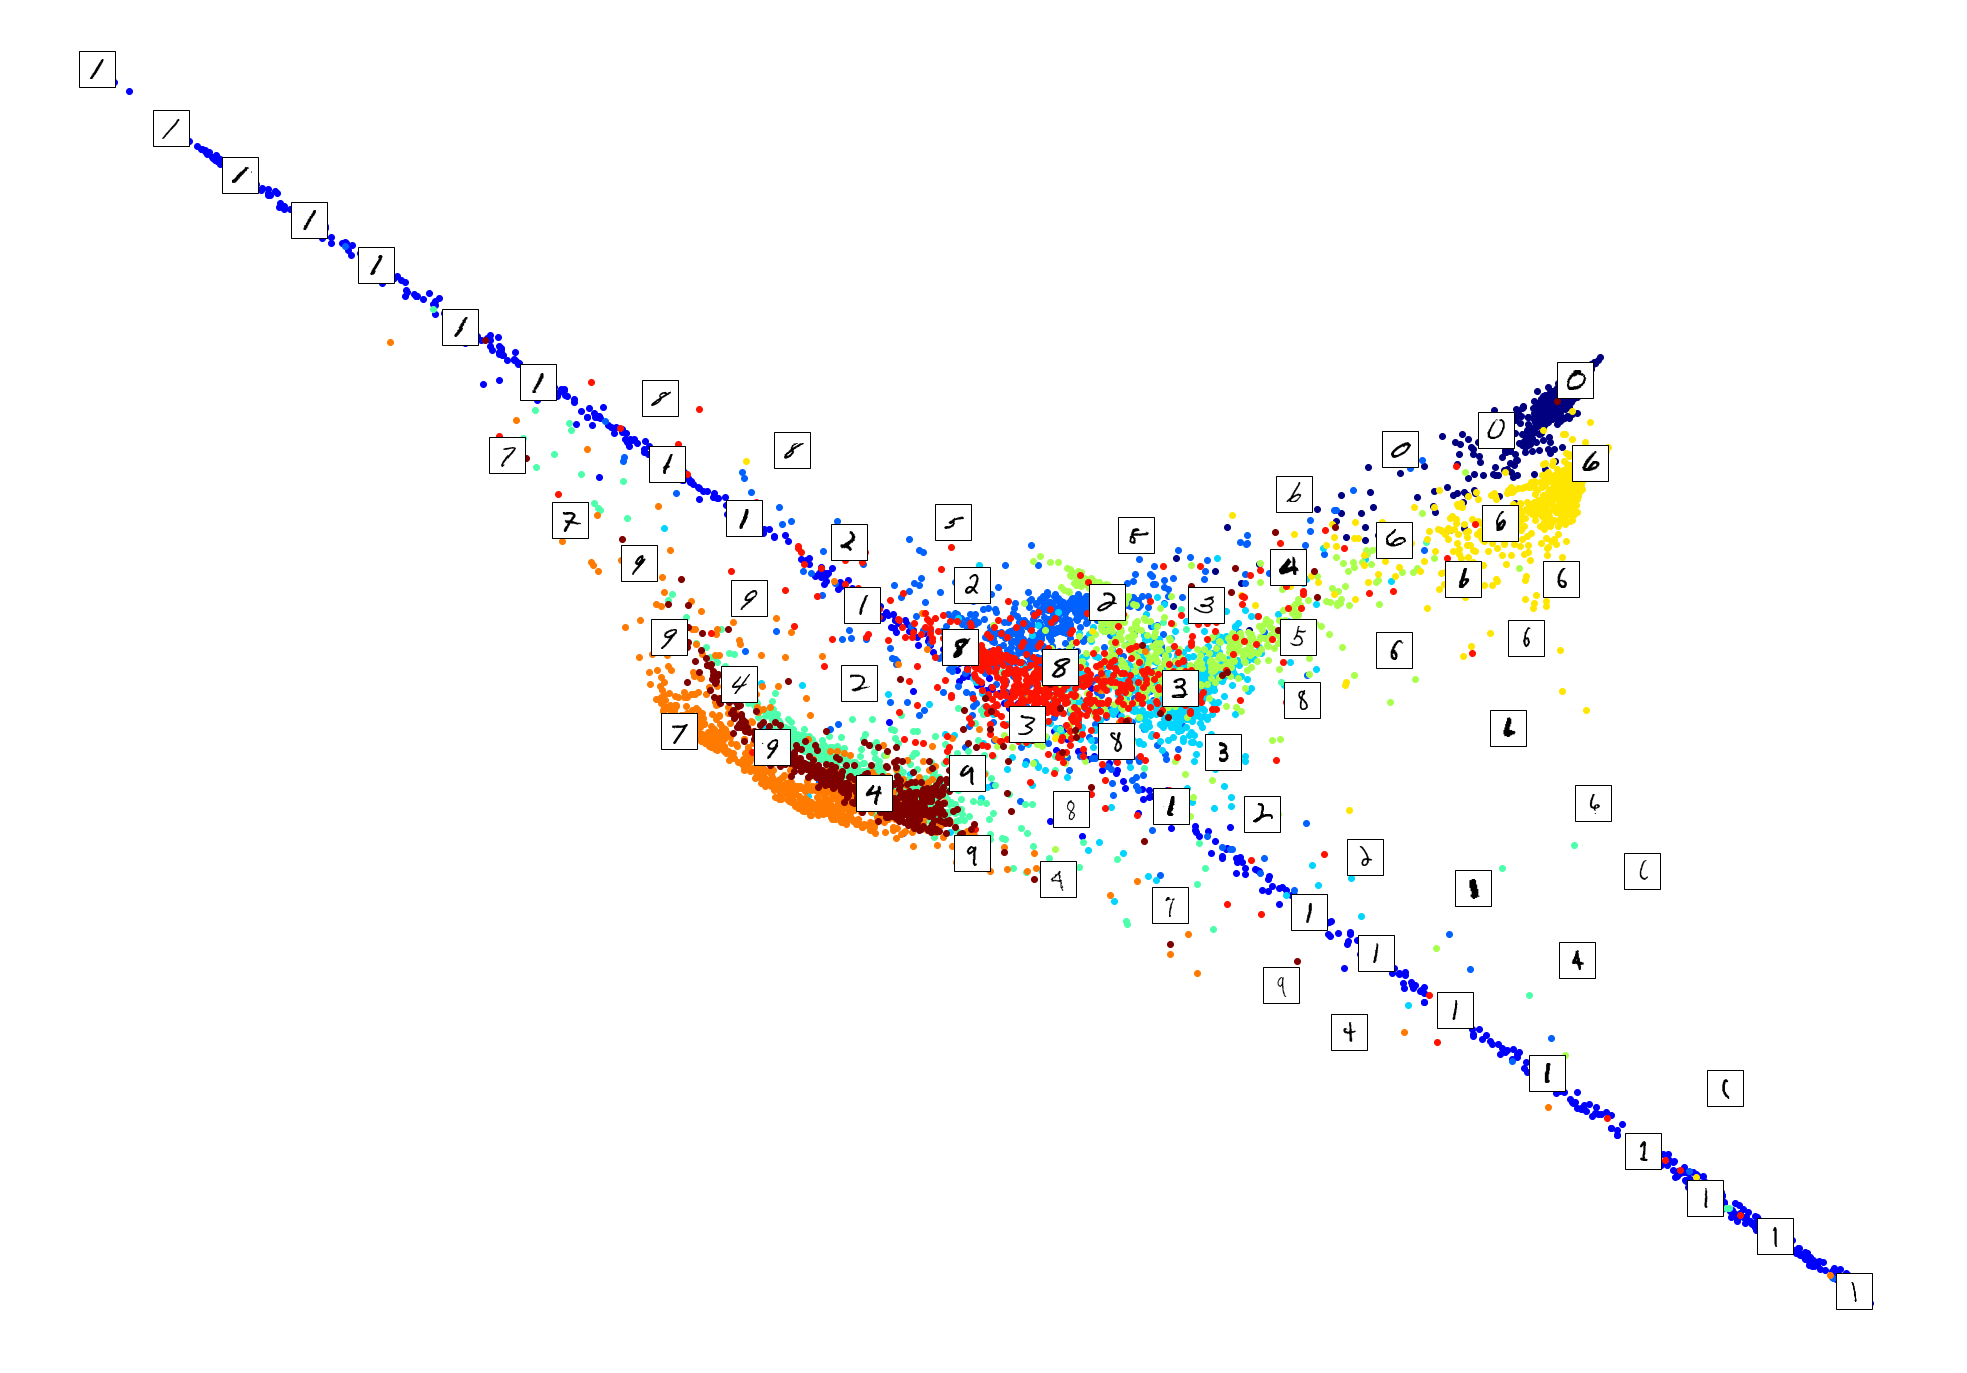

In [31]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_train_lle = lle.fit_transform(X_train)
plot_digits(X_train_lle, y_train, images=X_train, figsize=(35, 25))

In [35]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_train_isomap = isomap.fit_transform(X_train)

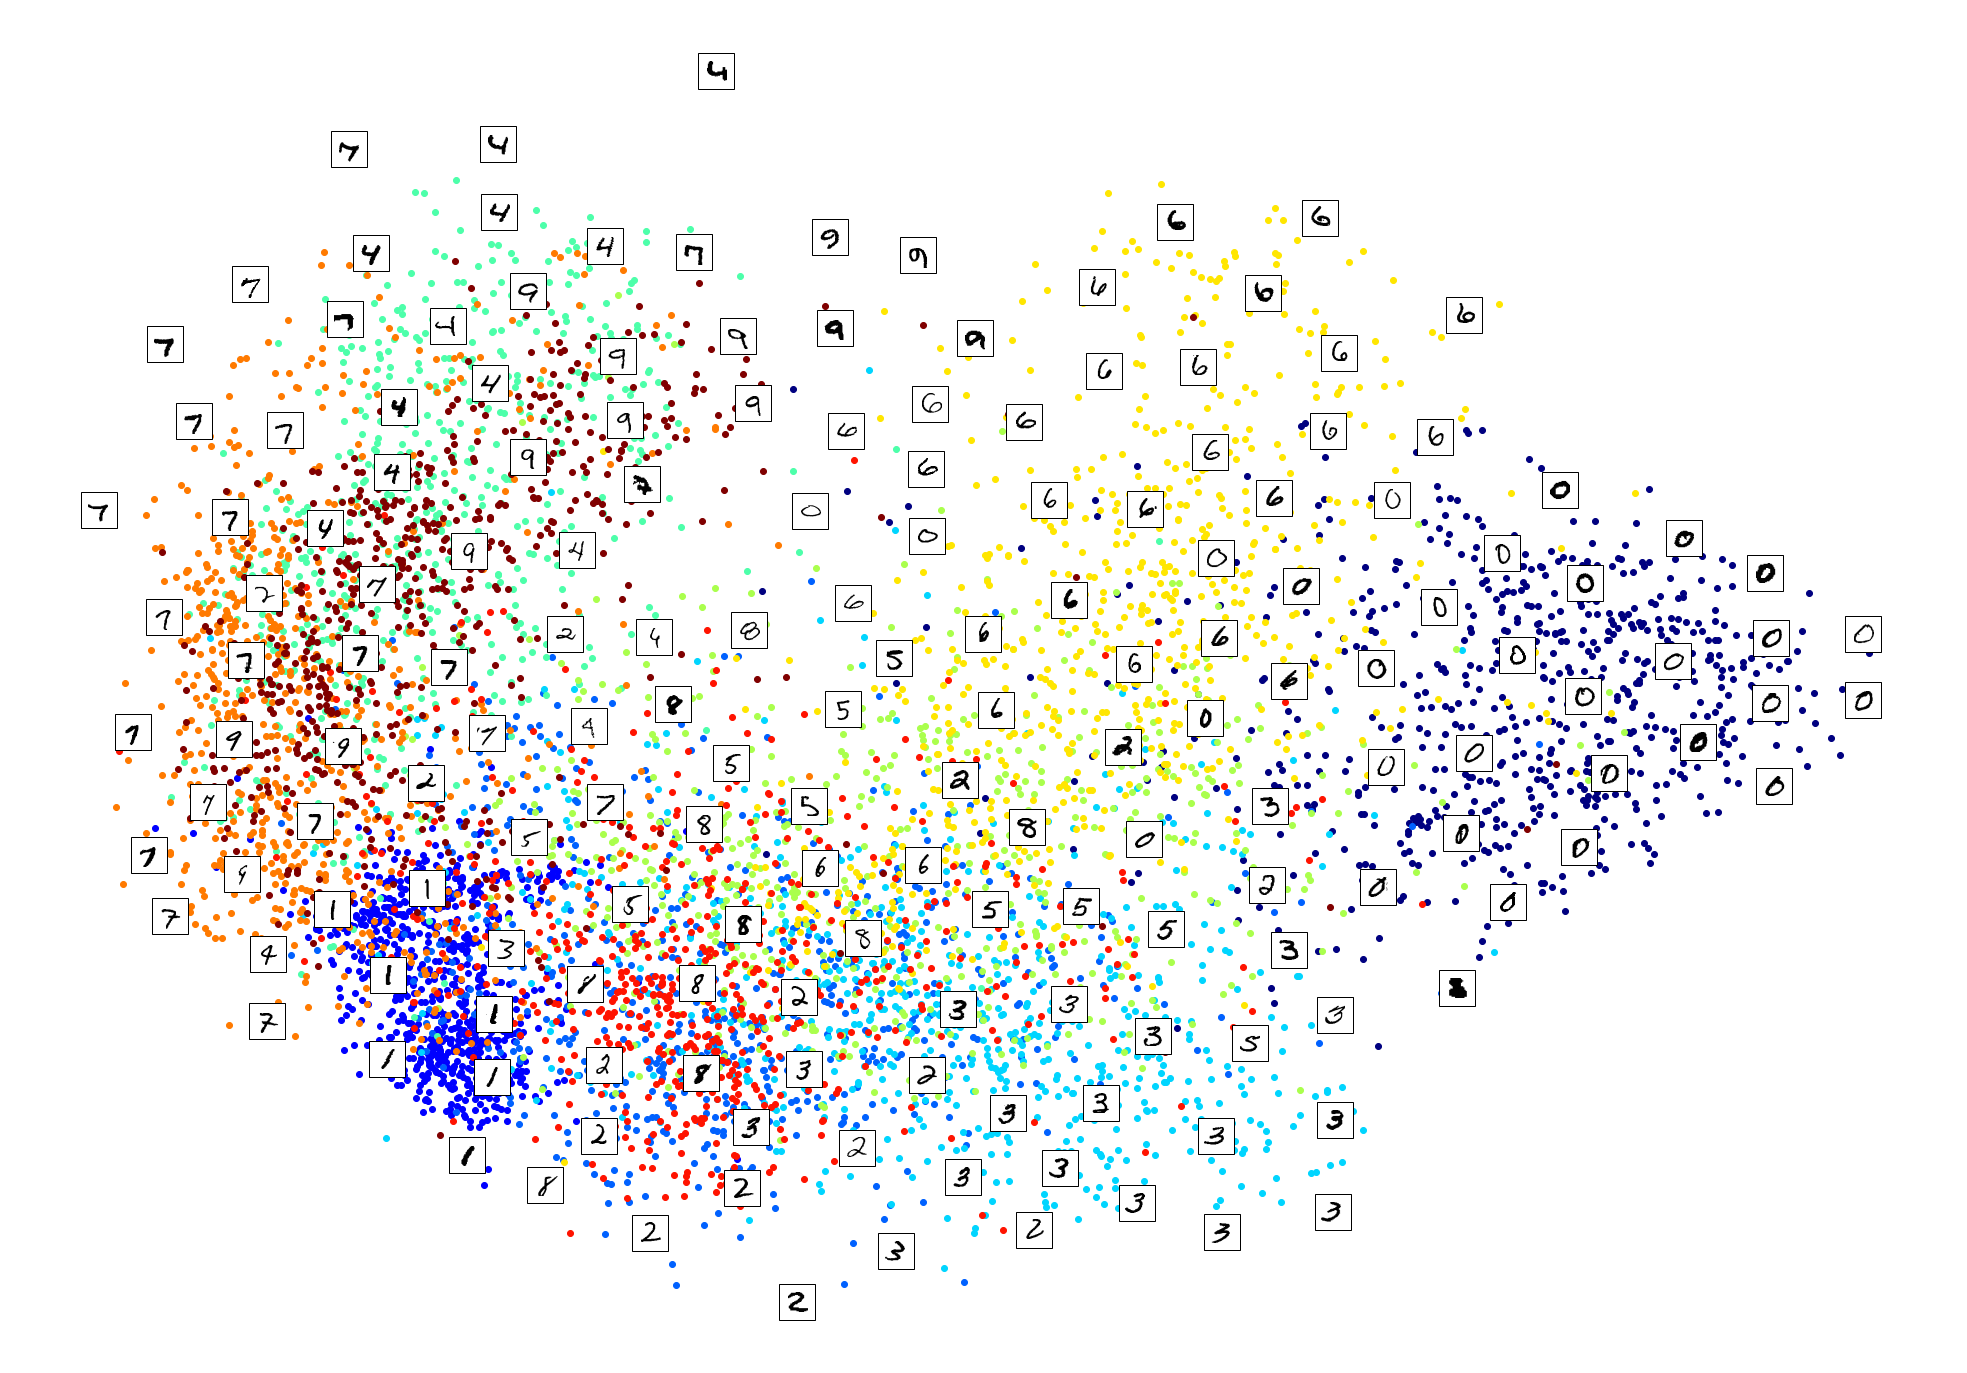

In [36]:
plot_digits(X_train_isomap, y_train, images=X_train, figsize=(35, 25))